# Synthetic data test: Proof of concept

The main goal of this synthetic is to show that the method works better than Euler Deconvolution. It will show how the solution converges. This is also the first synthetic that will be shown in the paper.

In [1]:
import numpy as np
import harmonica as hm
import verde as vd
import matplotlib.pyplot as plt
import xrft
import euler

## Create a model and data

Number of data: 5712


/home/leo/miniforge3/envs/euler-inversion/lib/python3.12/site-packages/xrft/xrft.py:573: FutureWarning: Default ifft's behaviour (lag=None) changed! Default value of lag was zero (centered output coordinates) and is now set to transformed coordinate's attribute: 'direct_lag'.
  warnings.warn(msg, FutureWarning)


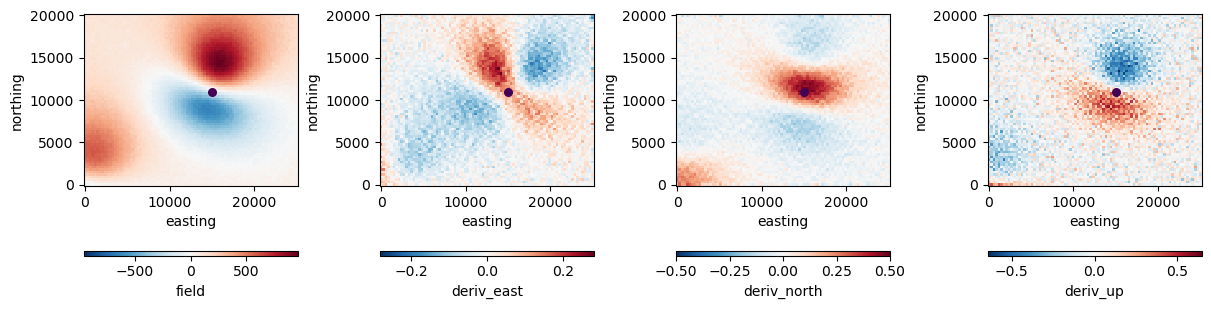

In [2]:
region = [0, 25e3, 0, 20e3]
coordinates = vd.grid_coordinates(region, spacing=300, extra_coords=800)
inclination, declination = -30, 15
base_level = 100
true_coordinates = (15e3, 11e3, -5e3)
magnetic_field = hm.dipole_magnetic(
    coordinates, 
    dipoles=true_coordinates,
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
main_field = hm.magnetic_angles_to_vec(1, inclination, declination)
magnetic_anomaly = sum(b * f for b, f in zip(magnetic_field, main_field))

# Interfering source
other = hm.dipole_magnetic(
    coordinates, 
    dipoles=(0e3, 0e3, -6e3),
    magnetic_moments=hm.magnetic_angles_to_vec(2e12, inclination, declination),
    field="b",
)
magnetic_anomaly += sum(b * f for b, f in zip(other, main_field))

# Add noise and the base level
magnetic_anomaly += np.random.default_rng(42).normal(0, 10, size=magnetic_anomaly.shape)
magnetic_anomaly += base_level

print(f"Number of data: {magnetic_anomaly.size}")

# Make a grid and calculate derivatives
# Can't have the height as a coordinate because of a problem with xrft
data = vd.make_xarray_grid(coordinates[:2], (magnetic_anomaly, coordinates[-1]), data_names=["field", "height"])
data["deriv_east"] = hm.derivative_easting(data.field)
data["deriv_north"] = hm.derivative_northing(data.field)
pad_width = {
    "easting": data.easting.size // 3,
    "northing": data.northing.size // 3,
}
padded = xrft.pad(data.field, pad_width, mode="linear_ramp", constant_values=None)
data["deriv_up"] = xrft.unpad(hm.derivative_upward(padded), pad_width)
# Add back the height
data = data.assign_coords(height=data.height)

fig, axes = plt.subplots(1, 4, figsize=(12, 5), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    data[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*true_coordinates[:2], c=true_coordinates[2], s=30)
plt.show()

## Euler Deconvolution

In [3]:
%%time
ed = euler.EulerDeconvolution(structural_index=3).fit_grid(data)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ed.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ed.location_}")
print(f"  STD       = {np.sqrt(np.diag(ed.covariance_))}")

Base level:
  True      = 100
  Estimated = 132.9242478487472
Position:
  True      = (15000.0, 11000.0, -5000.0)
  Estimated = [13378.66795268  9964.96498163 -3227.0019466 ]
  STD       = [127.18364893  84.66298954  56.05790157   2.67698644]
CPU times: user 3.56 ms, sys: 0 ns, total: 3.56 ms
Wall time: 3.31 ms


## Euler Inversion

In [4]:
%%time
ei = euler.EulerInversion(structural_index=3).fit_grid(data)
print("Base level:")
print(f"  True      = {base_level}")
print(f"  Estimated = {ei.base_level_}")
print("Position:")
print(f"  True      = {true_coordinates}")
print(f"  Estimated = {ei.location_}")
print(f"  STD       = {np.sqrt(np.diag(ei.covariance_))}")

Base level:
  True      = 100
  Estimated = 130.44791083805018
Position:
  True      = (15000.0, 11000.0, -5000.0)
  Estimated = [14958.70156852 10830.66055441 -4603.84446854]
  STD       = [472.50275299 292.69882668 206.8649726   11.35419579]
CPU times: user 12.6 s, sys: 8.54 ms, total: 12.6 s
Wall time: 6.02 s


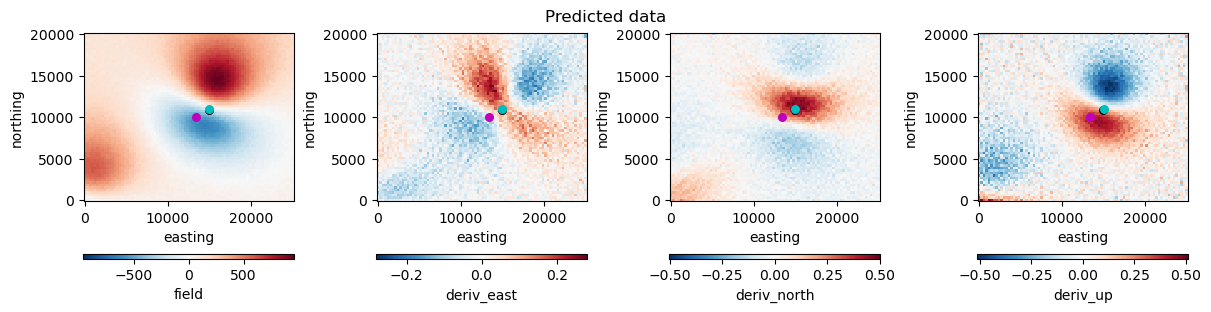

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3), layout='constrained')
for field, ax in zip(["field", "deriv_east", "deriv_north", "deriv_up"], axes.ravel()):
    ei.predicted_grid_[field].plot.pcolormesh(ax=ax, cbar_kwargs=dict(orientation="horizontal", aspect=50))
    ax.set_aspect("equal")
    tmp = ax.scatter(*ei.location_[:2], c="k", s=30)
    tmp = ax.scatter(*ed.location_[:2], c="m", s=30)
    tmp = ax.scatter(*true_coordinates[:2], c="c", s=30)
fig.suptitle("Predicted data")
plt.show()

## Show the process per iteration

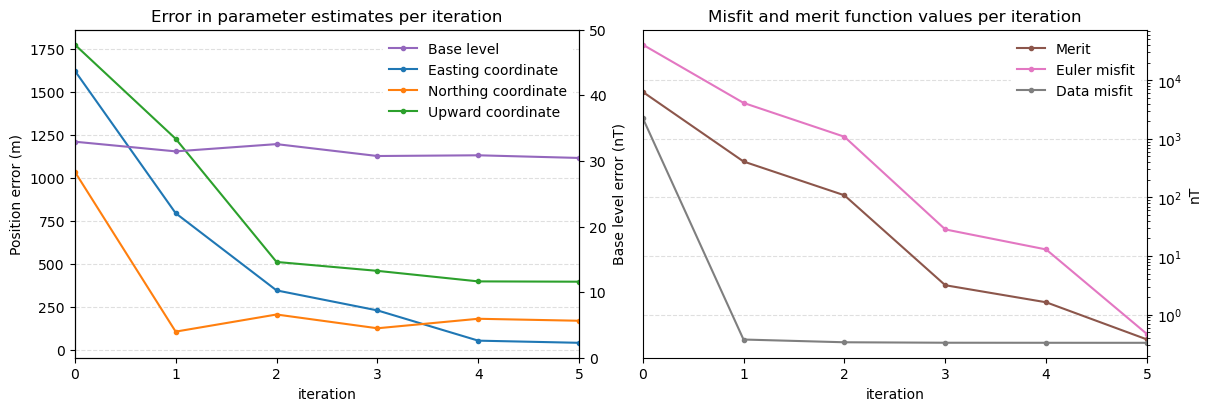

In [6]:
estimates = np.array(ei.location_per_iteration_)
east_error = np.abs(true_coordinates[0] - estimates[:, 0])
north_error = np.abs(true_coordinates[1] - estimates[:, 1])
up_error = np.abs(true_coordinates[2] - estimates[:, 2])
base_levels = np.array(ei.base_level_per_iteration_)
base_error = np.abs(base_level - base_levels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
colors = list(plt.rcParams['axes.prop_cycle'].by_key()['color'])

ax1.grid(axis="y", alpha=0.4, linestyle="--")
east, = ax1.plot(east_error, color=colors[0], marker=".", linestyle="-")
north, = ax1.plot(north_error, color=colors[1], marker=".", linestyle="-")
up, = ax1.plot(up_error, color=colors[2], marker=".", linestyle="-")
twin = ax1.twinx()
base, = twin.plot(base_error, color=colors[4], marker=".", linestyle="-")
ax1.legend(
    [base, east, north, up], 
    ["Base level", "Easting coordinate", "Northing coordinate", "Upward coordinate"],
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
twin.set_ylim(0, base_level / 2)
twin.set_ylabel("Base level error (nT)")
ax1.set_xlabel("iteration")
ax1.set_ylabel("Position error (m)")
ax1.set_title("Error in parameter estimates per iteration")
ax1.set_xlim(0, len(east_error) - 1)

ax2.grid(axis="y", alpha=0.4, linestyle="--")
ax2.plot(ei.merit_, label="Merit", color=colors[5], marker=".", linestyle="-")
ax2.plot(ei.euler_misfit_, label="Euler misfit", color=colors[6], marker=".", linestyle="-")
ax2.plot(ei.data_misfit_, label="Data misfit", color=colors[7], marker=".", linestyle="-")
ax2.legend(
    framealpha=1,
    facecolor="#ffffff",
    edgecolor="#ffffff",
)
ax2.set_yscale("log")
ax2.set_xlabel("iteration")
ax2.set_ylabel("nT")
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()
ax2.set_title("Misfit and merit function values per iteration")
ax2.set_xlim(0, len(east_error) - 1)

plt.show()